# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName("Project3_ys").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [3]:
listings = spark.read.option('header', True).\
    option('inferSchema', True).\
    option('multiLine', True).\
    option('escape', "\"").csv('../data/listings.csv')

In [87]:
reviews = spark.read.option('header', True).\
    option('inferSchema', True).\
    option('multiLine', True).\
    option('escape', "\"").csv('../data/reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [4]:
# Schema for listings.csv
listings.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [6]:
# size of listings.csv
print("The number of rows in listings.csv : {}".format(listings.count()))
print("The number of columns in listings.csv : {}".format(len(listings.columns)))

The number of rows in listings.csv : 408202
The number of columns in listings.csv : 106


In [ ]:
# Schema for reviews.csv
reviews.printSchema()

<font color="blue">这里为什么要drop comments column呀？</font>

In [91]:
reviews.drop('comments').take(5)

[Row(listing_id='145320', id='156423122', date='2017-05-30', reviewer_id='123386382', reviewer_name='Erwin'),
 Row(listing_id='145320', id='170211906', date='2017-07-15', reviewer_id='123091743', reviewer_name='Anne'),
 Row(listing_id='145320', id='172169175', date='2017-07-20', reviewer_id='78004', reviewer_name='Patricia'),
 Row(listing_id='145320', id='176647581', date='2017-07-31', reviewer_id='103178743', reviewer_name='Charlotte'),
 Row(listing_id='145320', id='185676021', date='2017-08-22', reviewer_id='4023961', reviewer_name='Alexander')]

In [ ]:
# size of reviews.csv
print("The number of rows in reviews.csv : {}".format(reviews.count()))
print("The number of columns in reviews.csv : {}".format(len(reviews.columns)))

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

<font color="blue">有个小小的问题，我看到.dropna()和na.drop()的功能是一样的，都是把所有有null value的row给drop掉。需要standardize一下代码吗？另外就是listings_filtered这个column之后没有再被用到，我暂时comment out了，后续需要删掉吗？</font>

In [7]:
# drop all NA values in listings and count the number of them
listings_na=listings.dropna()
listings_na.count()

95

In [ ]:
# listings_filtered = listings.filter(f.col('price').isNotNull())

In [ ]:
# drop all NA values in reviews and count the number of them
reviews_na=reviews.na.drop()
reviews_na.count()

In [ ]:
# We sampled 10% of the listings.csv and 5% of the reviews.csv
# We write them into local disk, listings_sample.csv and reviews_sample.csv

# No need to run now
# sample=df.sample(False, 0.05, 33)
# sample.coalesce(1).write.csv('data/names_here.csv')

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a table with the number of listings and neighbourhoods per city.

In [8]:
groupby_city=listings.groupBy('city').\
    agg(f.countDistinct('id').alias("Distinct Listings"),\
        f.countDistinct('neighbourhood_cleansed').alias("Distinct Neighbourhood")).cache()

In [9]:
groupby_city.show()

+--------------------+-----------------+----------------------+
|                city|Distinct Listings|Distinct Neighbourhood|
+--------------------+-----------------+----------------------+
|               Lorne|               69|                     1|
|             Palermo|             3693|                    14|
|              Tuglie|               52|                     2|
|         Agia Galini|               26|                     1|
|        Thessaloniki|              591|                     7|
|             Antwerp|               53|                    19|
|Paris-15E-Arrondi...|               23|                     1|
|           Aperregui|                1|                     1|
| Son Serra De Marina|                5|                     1|
|             Pennisi|                3|                     1|
|             Rinella|                6|                     1|
|       Hamilton Hill|                9|                     1|
|      Brunswick West|               21|

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [ ]:
# Let's check if Copenhagen fulfills the requirement:

In [10]:
groupby_city.filter(f.col("city") == "Copenhagen").show()

+----------+-----------------+----------------------+
|      city|Distinct Listings|Distinct Neighbourhood|
+----------+-----------------+----------------------+
|Copenhagen|              640|                    11|
+----------+-----------------+----------------------+



In [ ]:
# Yup, it does. We will choose Copenhagen for further analysis.

In [15]:
# extract listings that are in Copenhagen
# .cache() pulls data into a cluster-wide in-memory cache. This is very useful when data is accessed repeatedly.
copenhagen=listings.filter(f.col("city") == "Copenhagen").cache()

In [16]:
copenhagen.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [17]:
# compute and show with a table the number of listings per neighbourhood per property type in Copenhagen.
copenhagen_groupby=copenhagen.groupBy('neighbourhood_cleansed','property_type').\
                    agg(f.countDistinct('id').alias("Listings Count"))

In [18]:
copenhagen_groupby.show()

+----------------------+------------------+--------------+
|neighbourhood_cleansed|     property_type|Listings Count|
+----------------------+------------------+--------------+
|           Amager Vest|              Boat|             2|
|                Vanlse|         Apartment|            28|
|            Bispebjerg|Serviced apartment|             3|
|               sterbro|Serviced apartment|            44|
|           Amager Vest|              Loft|             3|
|            Bispebjerg|             House|            12|
|               Nrrebro|         Apartment|           618|
|          Brnshj-Husum|Serviced apartment|             1|
|                Vanlse|             House|            18|
|                 Valby|         Apartment|            44|
|  Vesterbro-Kongens...|        Guesthouse|             2|
|  Vesterbro-Kongens...|       Condominium|            35|
|  Vesterbro-Kongens...|         Townhouse|             9|
|              Indre By|              Loft|             

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [19]:
# from the schema, it can be seen that the price column is of type string 
# using regular expression, we clean the strings and then cast the column type to float
copenhagen_cleanPrice = copenhagen.\
        withColumn('price', f.regexp_replace('price', '\$', '')).\
        withColumn('price', f.regexp_replace('price', ',', '')).\
        withColumn('price', f.col('price').cast('float'))

In [20]:
# compute the minimum, maximum and average listing price in Copenhagen
copenhagen_cleanPrice.select(f.min('price'), f.max('price'), f.avg('price')).show()

+----------+----------+-----------------+
|min(price)|max(price)|       avg(price)|
+----------+----------+-----------------+
|      68.0|   55556.0|922.2381756756756|
+----------+----------+-----------------+



Compute and visualize the distribution of listing prices in your city.

In [21]:
# use groupby, count the number of listings at each price
price_distribution = copenhagen_cleanPrice.groupby("price").\
                        agg(f.countDistinct('id').alias("count"))

In [22]:
price_distribution.show()

+-------+-----+
|  price|count|
+-------+-----+
| 1331.0|    1|
|  362.0|    8|
|  955.0|    3|
|   82.0|    1|
|  697.0|   12|
|  798.0|  118|
| 2054.0|    1|
|  969.0|   22|
| 1863.0|    1|
| 1283.0|    1|
| 3603.0|    1|
|  546.0|   15|
| 2177.0|    1|
| 1802.0|   18|
| 2293.0|    1|
|  239.0|    2|
| 1496.0|    1|
|55556.0|    1|
| 1378.0|    8|
|  301.0|    8|
+-------+-----+
only showing top 20 rows



In [23]:
# create a price list for histogram
price_list=[]
for row in price_distribution.collect():
    price_list.extend([row['price']] * int(row['count']))

Visualize price distribution using histogram. Adjust the bins and bin size:

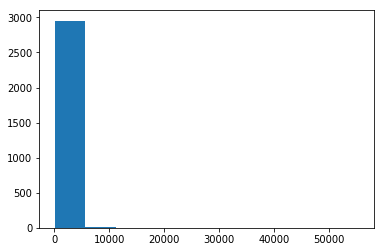

In [24]:
# 1. bin size = 10
plt.hist(price_list,bins=10)
plt.show()

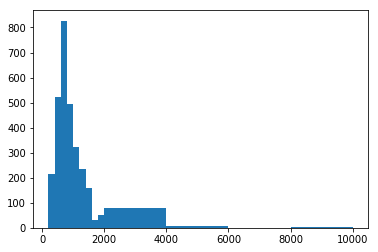

In [25]:
# 2. 13 bins, interval = 200, long tail (price>10000) ignored
plt.hist(price_list,
         bins = [200,400,600,800,1000,1200,1400,1600,1800,2000,4000,6000,8000,10000])
plt.show()

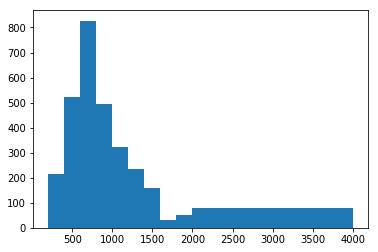

In [26]:
# 3. 10 bins, interval = 200, long tail (price>4000) ignored
plt.hist(price_list,
         bins = [200,400,600,800,1000,1200,1400,1600,1800,2000,4000])
plt.show()

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [27]:
# cast rating and price column into float, then compute the value of listings and store the results in a new column
copenhagen_value=copenhagen.\
        withColumn('review_scores_rating', f.col('review_scores_rating').cast('float')).\
        withColumn('price', f.regexp_replace('price', '\$', '')).\
        withColumn('price', f.regexp_replace('price', ',', '')).\
        withColumn('price', f.col('price').cast('float')).\
        withColumn('value', f.col('review_scores_rating')/f.col('price'))

In [28]:
# take a look at the first 2 rows of the table
copenhagen_value.select('review_scores_rating','price','value').take(2)

[Row(review_scores_rating=96.0, price=375.0, value=0.256),
 Row(review_scores_rating=99.0, price=2402.0, value=0.04121565362198168)]

In [29]:
# create a window and sort the table by value
value_window = Window.partitionBy('neighbourhood_cleansed').orderBy(f.desc('value'))
ranked_df = copenhagen_value.withColumn('valueRank', f.rank().over(value_window))

In [30]:
# show the top 3 valued listing in each neighbourhood
ranked_df.filter(f.col('valueRank') <= 3).\
    orderBy('neighbourhood_cleansed', f.desc('value')).\
    select('id','neighbourhood_cleansed','value','valueRank').show()

+--------+----------------------+-------------------+---------+
|      id|neighbourhood_cleansed|              value|valueRank|
+--------+----------------------+-------------------+---------+
|27815787|           Amager Vest| 1.3333333333333333|        1|
| 4831559|           Amager Vest|             0.9375|        2|
|12460024|           Amager Vest|0.41841004184100417|        3|
| 5710617|             Amager st| 0.6666666666666666|        1|
|  362647|             Amager st| 0.3861003861003861|        2|
| 3036965|             Amager st|0.38492063492063494|        3|
| 3658168|            Bispebjerg| 0.4311111111111111|        1|
| 7721166|            Bispebjerg|  0.419811320754717|        2|
|35671757|            Bispebjerg|0.37549407114624506|        3|
| 3388899|          Brnshj-Husum| 0.3609022556390977|        1|
| 2836381|          Brnshj-Husum|0.27624309392265195|        2|
| 2956470|          Brnshj-Husum| 0.2672413793103448|        3|
| 2708639|         Frederiksberg|0.31333

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [93]:
# join reviews and listings tables on listing id, and keep date and neighbourhood columns
joined=reviews.select('listing_id','date').\
            join(copenhagen.select('id','neighbourhood_cleansed'), 
                 f.col('listing_id') == f.col('id'))

In [94]:
joined.take(5)

[Row(listing_id='6983', date='2009-09-04', id='6983', neighbourhood_cleansed='Nrrebro'),
 Row(listing_id='6983', date='2009-09-07', id='6983', neighbourhood_cleansed='Nrrebro'),
 Row(listing_id='6983', date='2009-09-28', id='6983', neighbourhood_cleansed='Nrrebro'),
 Row(listing_id='6983', date='2009-12-17', id='6983', neighbourhood_cleansed='Nrrebro'),
 Row(listing_id='6983', date='2010-01-04', id='6983', neighbourhood_cleansed='Nrrebro')]

In [99]:
# craete a cache of the joined table for faster queries and operations
joined.cache()

DataFrame[listing_id: string, date: string, id: string, neighbourhood_cleansed: string]

In [100]:
# extract the year, month and date from the date column and store each in a separate column
joined_clean=joined.withColumn('year', f.col('date').substr(1,4)).\
                    withColumn('month', f.col('date').substr(6,2)).\
                    withColumn('day', f.col('date').substr(9,2)).\
                    drop('id')

In [101]:
joined_clean.show()

+----------+----------+----------------------+----+-----+---+
|listing_id|      date|neighbourhood_cleansed|year|month|day|
+----------+----------+----------------------+----+-----+---+
|      6983|2009-09-04|               Nrrebro|2009|   09| 04|
|      6983|2009-09-07|               Nrrebro|2009|   09| 07|
|      6983|2009-09-28|               Nrrebro|2009|   09| 28|
|      6983|2009-12-17|               Nrrebro|2009|   12| 17|
|      6983|2010-01-04|               Nrrebro|2010|   01| 04|
|      6983|2010-04-05|               Nrrebro|2010|   04| 05|
|      6983|2010-05-08|               Nrrebro|2010|   05| 08|
|      6983|2010-06-10|               Nrrebro|2010|   06| 10|
|      6983|2010-06-18|               Nrrebro|2010|   06| 18|
|      6983|2010-06-23|               Nrrebro|2010|   06| 23|
|      6983|2012-04-02|               Nrrebro|2012|   04| 02|
|      6983|2012-04-15|               Nrrebro|2012|   04| 15|
|      6983|2012-04-21|               Nrrebro|2012|   04| 21|
|      6

In [102]:
# craete a cache for faster queries and operations
joined_clean.cache()

DataFrame[listing_id: string, date: string, neighbourhood_cleansed: string, year: string, month: string, day: string]

In [125]:
# count the number of reviews over the years
gb_year=joined_clean.groupBy('year').count().\
                withColumn('year', f.col('year').cast('Integer')).\
                orderBy('year', ascending=True)

In [126]:
gb_year.show()

+----+-----+
|year|count|
+----+-----+
|2009|    4|
|2010|   39|
|2011|  243|
|2012| 1034|
|2013| 3570|
|2014| 8279|
|2015|12817|
|2016|14391|
|2017|13572|
|2018|12929|
|2019|10006|
+----+-----+



In [127]:
# export and visualize
year = [row['year'] for row in gb_year.collect()]
review_count=[row['count'] for row in gb_year.collect()]

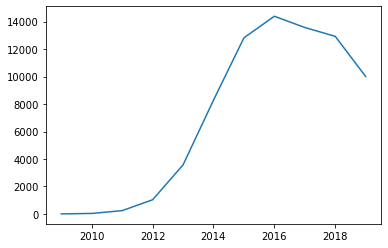

In [128]:
plt.plot(year,review_count)
plt.show()

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [129]:
gb_neighbor_year=joined_clean.groupBy('neighbourhood_cleansed', 'year').count().\
                withColumn('year', f.col('year').cast('Integer')).\
                orderBy(['neighbourhood_cleansed','year'], ascending=[1,1])

In [130]:
gb_neighbor_year.show()

+----------------------+----+-----+
|neighbourhood_cleansed|year|count|
+----------------------+----+-----+
|           Amager Vest|2012|   71|
|           Amager Vest|2013|  341|
|           Amager Vest|2014|  593|
|           Amager Vest|2015|  960|
|           Amager Vest|2016| 1319|
|           Amager Vest|2017| 1160|
|           Amager Vest|2018| 1180|
|           Amager Vest|2019|  917|
|             Amager st|2012|   83|
|             Amager st|2013|  179|
|             Amager st|2014|  574|
|             Amager st|2015|  834|
|             Amager st|2016|  753|
|             Amager st|2017|  760|
|             Amager st|2018|  714|
|             Amager st|2019|  533|
|            Bispebjerg|2012|   11|
|            Bispebjerg|2013|   58|
|            Bispebjerg|2014|  184|
|            Bispebjerg|2015|  360|
+----------------------+----+-----+
only showing top 20 rows



In [132]:
dic={}
for row in gb_neighbor_year.collect():
    if row['neighbourhood_cleansed'] in dic:
        dic[row['neighbourhood_cleansed']] += [(row['year'],row['count'])]
    else:
        dic[row['neighbourhood_cleansed']] = [(row['year'],row['count'])]
dic

{'Amager Vest': [(2012, 71),
  (2013, 341),
  (2014, 593),
  (2015, 960),
  (2016, 1319),
  (2017, 1160),
  (2018, 1180),
  (2019, 917)],
 'Amager st': [(2012, 83),
  (2013, 179),
  (2014, 574),
  (2015, 834),
  (2016, 753),
  (2017, 760),
  (2018, 714),
  (2019, 533)],
 'Bispebjerg': [(2012, 11),
  (2013, 58),
  (2014, 184),
  (2015, 360),
  (2016, 432),
  (2017, 393),
  (2018, 356),
  (2019, 335)],
 'Brnshj-Husum': [(2013, 1),
  (2014, 24),
  (2015, 52),
  (2016, 105),
  (2017, 125),
  (2018, 106),
  (2019, 63)],
 'Frederiksberg': [(2011, 2),
  (2012, 30),
  (2013, 70),
  (2014, 99),
  (2015, 172),
  (2016, 222),
  (2017, 201),
  (2018, 190),
  (2019, 159)],
 'Indre By': [(2010, 5),
  (2011, 58),
  (2012, 215),
  (2013, 790),
  (2014, 2172),
  (2015, 3365),
  (2016, 3561),
  (2017, 3406),
  (2018, 3304),
  (2019, 2589)],
 'Nrrebro': [(2009, 4),
  (2010, 12),
  (2011, 77),
  (2012, 306),
  (2013, 1155),
  (2014, 2171),
  (2015, 2955),
  (2016, 3234),
  (2017, 2889),
  (2018, 2793),
  

In [179]:
def plot():    
    fig, ax = plt.subplots(4, 3, figsize=(30,20))
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
    
    for index,key in enumerate(dic.keys()):
        row = index//3
        col = index%3      
        ax[row, col].set_title(key)
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Review Count")
        ax[row, col].plot([x[0] for x in dic[key]], [x[1] for x in dic[key]])

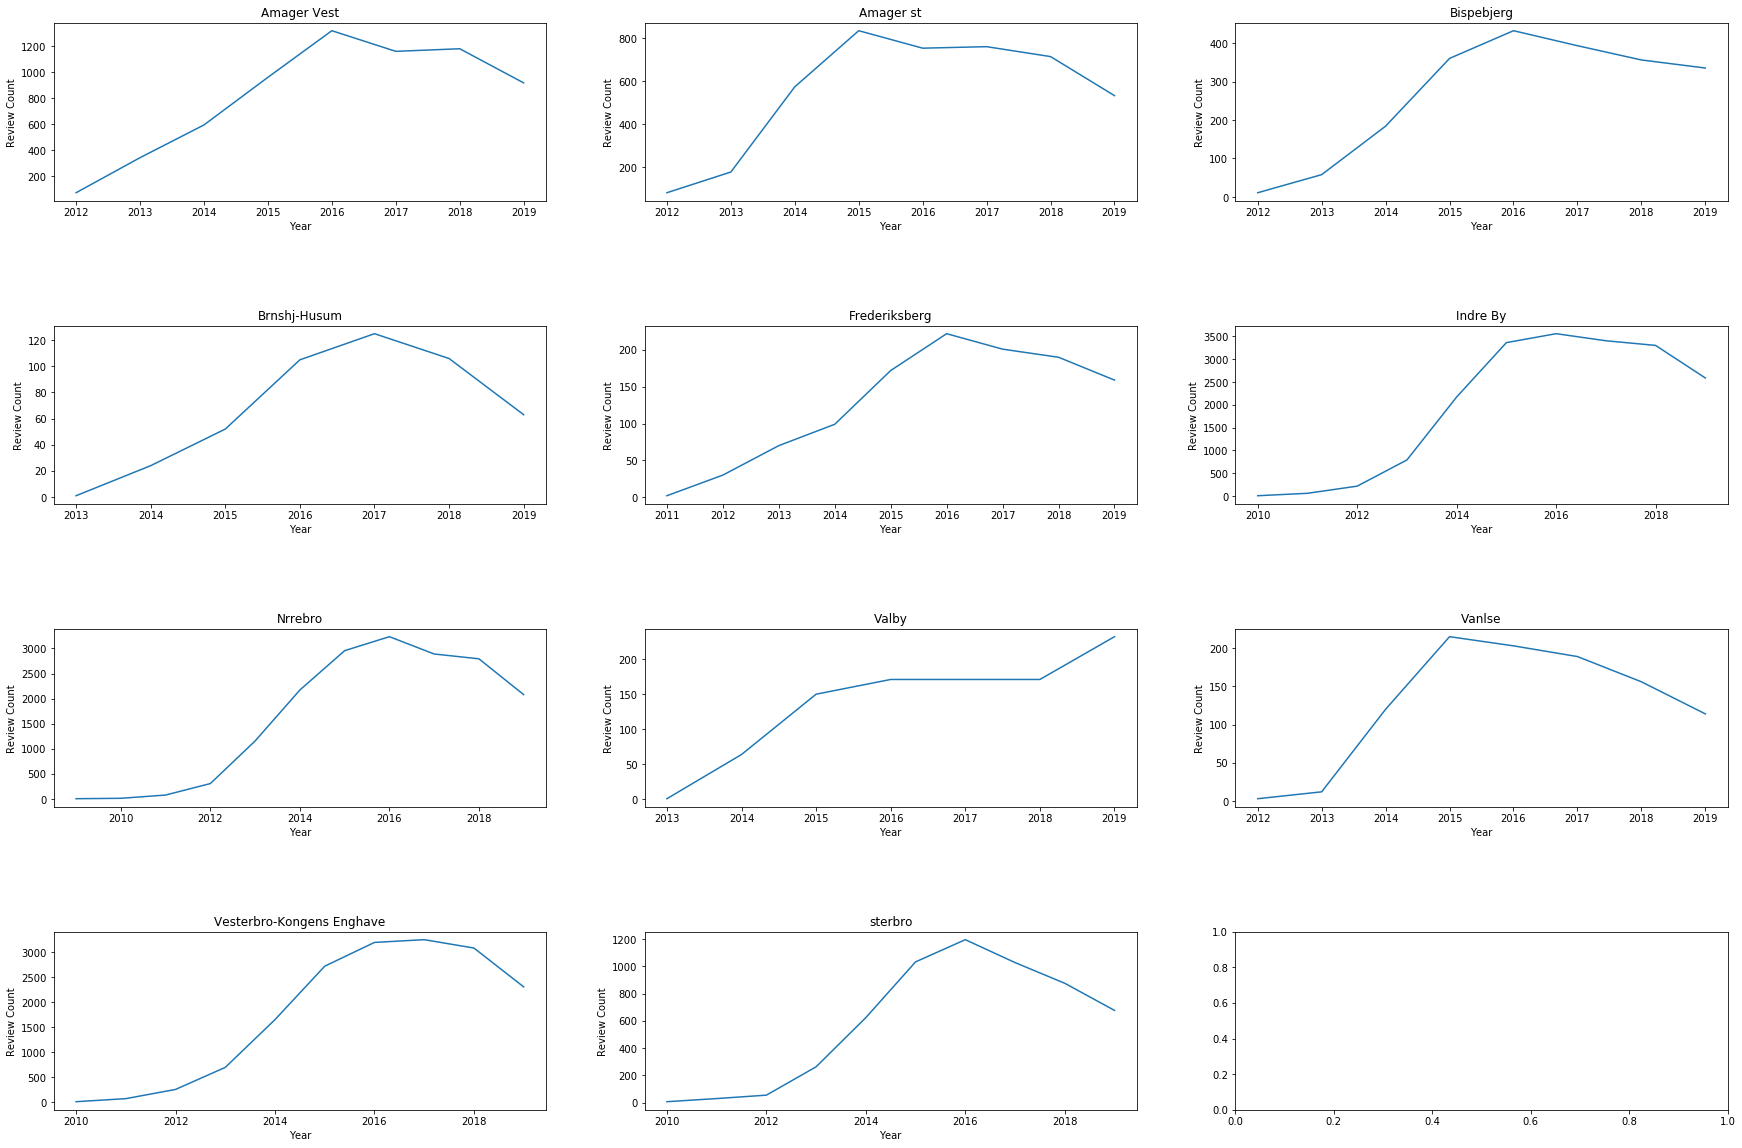

In [180]:
plot()

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [138]:
gb_month=joined_clean.groupBy('month').count().\
                withColumn('month', f.col('month').cast('Integer')).\
                orderBy('month', ascending=True)

In [139]:
gb_month.show()

+-----+-----+
|month|count|
+-----+-----+
|    1| 3471|
|    2| 3074|
|    3| 3998|
|    4| 5979|
|    5| 9385|
|    6| 9035|
|    7|10139|
|    8|11686|
|    9| 7562|
|   10| 4918|
|   11| 3759|
|   12| 3878|
+-----+-----+



In [140]:
month = [row['month'] for row in gb_month.collect()]
review_count=[row['count'] for row in gb_month.collect()]

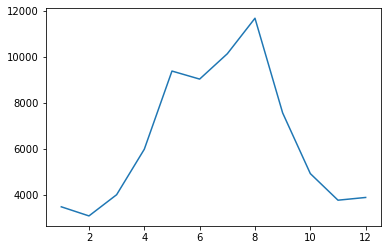

In [141]:
plt.plot(month,review_count)
plt.show()

In [142]:
# to observe seasonality

In [143]:
gb_year_month=joined_clean.groupBy('year','month').count().\
                withColumn('year', f.col('year').cast('Integer')).\
                withColumn('month', f.col('month').cast('Integer')).\
                orderBy(['year','month'], ascending=[1,1])

In [144]:
gb_year_month.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2009|    9|    3|
|2009|   12|    1|
|2010|    1|    1|
|2010|    4|    1|
|2010|    5|    1|
|2010|    6|    5|
|2010|    7|    4|
|2010|    8|   12|
|2010|    9|    5|
|2010|   10|    3|
|2010|   11|    4|
|2010|   12|    3|
|2011|    1|    6|
|2011|    2|    4|
|2011|    3|    7|
|2011|    4|   12|
|2011|    5|   15|
|2011|    6|   20|
|2011|    7|   22|
|2011|    8|   48|
+----+-----+-----+
only showing top 20 rows



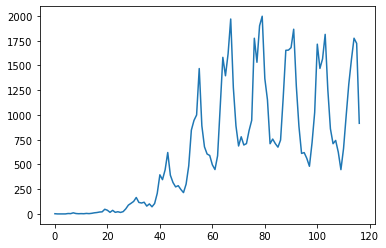

In [146]:
review_count=[row['count'] for row in gb_year_month.collect()]
plt.plot(review_count)
plt.show()

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

1. select id and rating from listings
2. select id and comment from reviews
3. join two on id

4. define user defined function udf e.g.
 ``` python
def extract_title(name):
    name_parts = name.split(',')
    title_and_first = name_parts[1].split('.')
    return title_and_first[0]
extract_title_udf = f.udf(extract_title)
df.withColumn('Title', extract_title_udf(f.col('Name'))).select('Name', 'Title').show()
    ```
5. use udf to clean comment column --> remove stop words, common words blah blah, stemming maybe? stemming maybe too computational expensive, we could omit.

6. store in a dic, key == rating , value == comment. if same rating, just concat comments. after iterations, value should be very long (few comments concat)

7. tokenize comment, assign rate to each token and store avg rating for each word in a new dic. Lets say original dic is {7 : "it is good", 8: "it looks good and fantastic"}, the new dic will be {'good' : (7+8)/2 = 7.5, "fantastic" : 8}

8. return the highest score words

a few concerns:
1. too many words invloved, i am not sure if a dic is appropriate, maybe should use streaming sketch, i do not know..

2. only considered listing rating in positivity weight. "For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review." maybe consider others, keep a counter on how many times this word appears, below a threshold then drop. This may help with point 1.

3. yes, memory space is a concern...can we store so many words in memory?